<a href="https://colab.research.google.com/github/charliecarver/cosc247/blob/master/deliverable-3/deliverable-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [8]:
# Load CSV files from remote repo
import requests
import zipfile
import io

r = requests.get('https://github.com/charliecarver/cosc247/blob/master/datasets.zip?raw=true')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
testPath = 'Test.csv'
trainPath = 'Train.csv'

## Single-File Deliverable

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import scipy.sparse
import string
from ast import literal_eval
import nltk.tokenize
import nltk.stem.porter
import math
from nltk.corpus import stopwords
import sklearn.metrics
import statistics
import sklearn.naive_bayes
import sklearn.feature_extraction.text
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import sklearn.model_selection
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.tree
import sklearn.linear_model
from sklearn.metrics import classification_report, confusion_matrix
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from matplotlib import ticker
from sklearn.tree import export_graphviz
import graphviz
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
import sklearn.linear_model
import sklearn.model_selection
import statistics
import nltk
import sklearn.feature_selection
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Flags
useTestCSV = False
#NGRAM_SIZE = 2
NGRAM_SIZE = 4
#COMMON_WORD_THRESHOLD = 10
COMMON_WORD_THRESHOLD = 4
stemmer = nltk.stem.porter.PorterStemmer()

def preprocessForTextClassification(df):
    df['reviewText'] = df['reviewText'].fillna("")
    df['summary'] = df['summary'].fillna("")

    P = df.groupby('amazon-id').agg({
        'reviewText': ' '.join,
        'summary': ' '.join,
    })

    P['reviewText'] = P['reviewText'] + " " + P['summary']

    return P


# Train text classifier
def trainTextFrequency(df):
    P = preprocessForTextClassification(df)

    #vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1,NGRAM_SIZE))
    vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1,NGRAM_SIZE), min_df=COMMON_WORD_THRESHOLD, preprocessor=lambda token: stemmer.stem(token))
    X1 = vectorizer.fit_transform(P['reviewText'])

    return X1, vectorizer

def getTextMatrix(df, word_indices):
    P = preprocessForTextClassification(df)

    X1 = word_indices.transform(P['reviewText'])
    return X1

# function for normalization
def normalize_column_data(input_data):
    for feature in input_data:    
        input_data[feature] = (input_data[feature]-input_data[feature].min())/(input_data[feature].max()-input_data[feature].min())

# Process numerical data
def processNumerical(df):

    # Drop text data
    df = df.drop(columns=['title', 'categories', 'songs', 'related', 'reviewTime'])

    # Drop columns that need more time to process
    #df = df.drop(columns=['label', 'first-release-year'])
    df = df.drop(columns=['label'])
    df['first-release-year'].fillna((df['first-release-year'].median()), inplace=True)
    df['first-release-year'] = df['first-release-year'].apply(lambda x: 1 if x > 1990 else 0)
    
    # Transform helpful into "ratio" of being helpful
    df['helpful'] = df['helpful'].apply(lambda x: np.nan if literal_eval(x)[1]== 0 else literal_eval(x)[0]/literal_eval(x)[1])
    df['helpful'].fillna((df['helpful'].median()), inplace=True)
    
    # review counter for each review
    df['review_count'] = 1

    # Convert categorical data to their own features
    # df = df.join(pd.get_dummies(df['root-genre']))
    df = df.drop(columns=['root-genre'])

    # Return processed data
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lupan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lupan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lupan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lupan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
# Load data
try:
    testPath
except NameError:
    # Default paths of CSV files
    print('Loading files from default locations')
    testPath = 'Test.csv'
    trainPath = 'Train.csv'

# Load dataframes
dfTrain = pd.read_csv(trainPath)
if useTestCSV: dfTest = pd.read_csv(testPath)

# Train text classifier on training data
trainingTextMatrix, wordIndices = trainTextFrequency(dfTrain)

# Process textual data
if useTestCSV:
    testTextMatrix = getTextMatrix(dfTest, wordIndices)

# Process numerical data
dfTrain = processNumerical(dfTrain)
if useTestCSV: dfTest = processNumerical(dfTest)

In [11]:
dfTrain

,reviewerID,amazon-id,helpful,unixReviewTime,reviewText,overall,summary,price,artist,first-release-year,salesRank,review_count
0,-4984057859803657856,1877521326299865484,1.000000,1302739200,Very nice music for practicing my Tai Chi. I d...,4,Beautiful,16.47,-7180760356347753735,1,27222,1
1,9136764282801708742,1877521326299865484,1.000000,1180396800,I recently starting doing Tai Chi which I love...,5,Tranquillity In Motion !!!,16.47,-7180760356347753735,1,27222,1
2,2164551966908582519,1877521326299865484,0.875000,1361404800,My wife uses it for her class room the kids lo...,5,Great Stuff,16.47,-7180760356347753735,1,27222,1
3,-7309200698931694843,1877521326299865484,1.000000,1338163200,We bought this music to go Dr Lam DVD. The mus...,5,Beautiful,16.47,-7180760356347753735,1,27222,1
4,-4461682407031037732,1877521326299865484,0.875000,1396310400,It helps me do my exercise because it sets the...,5,tai chi music,16.47,-7180760356347753735,1,27222,1
...,...,...,...,...,...,...,...,...,...,...,...,...
111093,-508419005999372045,-272019625357917459,0.875000,1405900800,Nice soundtrack and I was pleasantly surprised...,4,Four Stars,33.76,-3758738156872779256,1,6,1
111094,4690686471314282919,-272019625357917459,0.923077,1405209600,I'd you are looking for the music that they sa...,5,I'd you are looking for the music that they sa...,33.76,-3758738156872779256,1,6,1
111095,-6735807132142826990,-272019625357917459,0.750000,1404259200,FANTASTIC FILM! Loved this movie and the musi...,5,FANTASTIC FILM! Loved this movie and the music,33.76,-3758738156872779256,1,6,1
111096,6536263939078780437,2197509461459270640,0.875000,1404518400,"A great new CD with uptempo, funky guitar. Thi...",5,A great new CD with uptempo,32.98,2800811401610696293,1,24972,1


In [13]:
# Aggregate training
isAwesome = lambda x: 1 if np.mean(x) > 4.5 else 0
trainData = dfTrain.groupby('amazon-id').agg({
    'unixReviewTime': 'mean',
    'price': 'mean',
    'overall': isAwesome,
    'salesRank': 'mean',
    'helpful': 'mean',
    'first-release-year': 'mean',
    'review_count': 'sum'
})

# normalization for numerical features
normalize_column_data(trainData)

# Aggregate testing data and split into dependent/independent vars
if useTestCSV:
    testData = dfTest.groupby('amazon-id').agg({
        'unixReviewTime': 'mean',
        'price': 'mean',
        'salesRank': 'mean',
        'helpful': 'mean',
        
        # TODO first release year
    })
    normalize_column_data(testData)
    
    ytrain = trainData['overall'].to_numpy()
    # Todo here using review time, price and others. Let's make consistenet with "else" part for 'helpful only'
    Xtrain = scipy.sparse.hstack(
        (trainingTextMatrix, scipy.sparse.csr_matrix(trainData.drop(columns='overall').to_numpy()))
    )
    Xtrain = scipy.sparse.csr_matrix(Xtrain)
    testIndex = testData.index
    Xtest = scipy.sparse.hstack(
        (testTextMatrix, scipy.sparse.csr_matrix(testData.to_numpy()))
    )
    Xtest = scipy.sparse.csr_matrix(Xtest)

else:
    """
    #ablation_columns = ['unixReviewTime', 'price', 'salesRank', 'helpful', 'first-release-year', 'review_count']
    ablation_columns = ['first-release-year', 'review_count']

    Xtrain = scipy.sparse.csr_matrix(scipy.sparse.hstack(
        (trainingTextMatrix, scipy.sparse.csr_matrix(trainData[ablation_columns].to_numpy()))
    ))
    
    ytrain = trainData['overall'].to_numpy()
    selector = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k=7000)
    Xtrain = selector.fit_transform(Xtrain, ytrain)
    Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(Xtrain, trainData['overall'].to_numpy(), test_size=0.3, shuffle=True)
    """
    
    print("Splitting training data into testing and training sets...")
    ablationColumns = ['first-release-year', 'review_count']
    XTrain = scipy.sparse.csr_matrix(scipy.sparse.hstack(
        (trainingTextMatrix, scipy.sparse.csr_matrix(trainData[ablationColumns].to_numpy()))
    ))
    
    # Construct y training data
    yTrain = trainData['overall'].to_numpy()
    
    # Select KBest features from training set
    selection = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k=7000).fit(XTrain, yTrain)
    
    # Transform X training data based on KBest features 
    XTrain = selection.transform(XTrain)
    
    # Split training data into training + testing sets
    XTrain, XTest, yTrain, yTest = sklearn.model_selection.train_test_split(XTrain, trainData['overall'].to_numpy(), test_size=0.3, shuffle=True)


Splitting training data into testing and training sets...


In [ ]:
scores = selector.scores_
scores /= scores.max()
scores

In [ ]:
trainData

## Voting

In [16]:
voting_flag = False

# Testing
if not useTestCSV:
    # Run ML
    #kf = sklearn.model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)
    f1_vals_log = []
    f1_vals_rnd = []
    f1_vals_svm = []
    f1_vals_gnb = []
    f1_vals_voting = []
    
    #log_clf = sklearn.linear_model.LogisticRegression(max_iter=100000, class_weight='balanced')
    #log_clf = sklearn.linear_model.LogisticRegression(max_iter=100000, multi_class='multinomial', C=1.0, class_weight='balanced', penalty='l2')
    log_clf = sklearn.linear_model.LogisticRegression(C=6.97, class_weight='balanced', max_iter=100000, multi_class='multinomial')
    # for soft
    #svm_rbf_clf = SVC(kernel='linear', probability=True)
    # for hard
    #svm_rbf_clf = SVC(kernel='linear')
    svm_rbf_clf = SVC(C=5.5, class_weight='balanced', kernel='linear', max_iter=5000000)
    rnd_clf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
    MNBclf = MultinomialNB()
    gnb_clf = sklearn.naive_bayes.GaussianNB()
    #voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svm', svm_rbf_clf)], voting='hard')
    voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('svm', svm_rbf_clf)], voting='hard')
    
    # ('gnb', gnb_clf)
    #clf_list = [log_clf, rnd_clf, svm_rbf_clf, voting_clf]
    clf_list = [log_clf, svm_rbf_clf, voting_clf]
    
    for train_index, test_index in kf.split(Xtrain):
        x_train, x_test = Xtrain[train_index], Xtrain[test_index]
        y_train, y_test = ytrain[train_index], ytrain[test_index]
        
        if voting_flag:
            print("==================================================")
            for clf in clf_list:
                clt = clf.fit(x_train, y_train)
                f1 = sklearn.metrics.f1_score(y_test, clt.predict(x_test), average='weighted')

                if clf == log_clf:
                    print("logistic regression")
                    f1_vals_log.append(f1)
                elif clf == rnd_clf:
                    print("random forest")
                    f1_vals_rnd.append(f1)
                elif clf == gnb_clf:
                    print("Gaussian Naive")
                    f1_vals_gnb.append(f1)
                elif clf == svm_rbf_clf:
                    print("SVM")
                    f1_vals_svm.append(f1)
                else:
                    print("voting")
                    f1_vals_voting.append(f1)
                print("F1 {}".format(f1))

        else:
            clt = log_clf.fit(x_train, y_train)
            f1 = sklearn.metrics.f1_score(y_test, clt.predict(x_test), average='weighted')
            f1_vals_log.append(f1)
            print("F1 {}".format(f1))

    if voting_flag:    
        print("Mean F1 LR: ", statistics.mean(f1_vals_log))
        #print("Mean F1 RF: ", statistics.mean(f1_vals_rnd))
        print("Mean F1 SVM: ", statistics.mean(f1_vals_svm))
        print("Mean F1 voting: ", statistics.mean(f1_vals_voting))
    else:
        print("Mean F1 LR: ", statistics.mean(f1_vals_log))
    # print(sklearn.metrics.f1_score(ytest, ypreds, average='weighted'))

# Output CSV file with predictions
if useTestCSV:

    LR = sklearn.linear_model.LogisticRegression(max_iter=100000, class_weight='balanced')
    LRTrained = LR.fit(Xtrain, ytrain)
    ypreds = LRTrained.predict(Xtest)
    # Output predictions for deliverable
    output = pd.DataFrame({'amazon-id': testIndex, 'Awesome': ypreds})
    output.to_csv('./Product_Predictions.csv')
    print("Output to ./Product_Predictions.csv")

F1 0.7941496509761808
F1 0.7867718652567354
F1 0.8005935462354877
F1 0.8003475050872718
F1 0.7863436137854908
F1 0.763928073754184
F1 0.7873760689143338
F1 0.7847479928082485
F1 0.8062883243854556
F1 0.7958948142722969
Mean F1 LR:  0.7906441455475686


In [61]:
statistics.stdev(f1_vals_log)

0.014266809920862752

In [62]:
statistics.stdev(f1_vals_svm)

0.0133013763316611

## Ablation column

In [26]:
def powerset(seq):
    """
    Returns all the subsets of this set. This is a generator.
    """
    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item

In [66]:
ablation_columns = ['unixReviewTime', 'price', 'salesRank', 'helpful', 'first-release-year', 'review_count']
log_clf = sklearn.linear_model.LogisticRegression(C=6.97, class_weight='balanced', max_iter=100000, multi_class='multinomial')
svm_rbf_clf = SVC(C=5.5, class_weight='balanced', kernel='linear', max_iter=5000000)
#clf_list = [log_clf, svm_rbf_clf]
clf_list = [log_clf]

feature_combination = [x for x in powerset(ablation_columns)]
entire_performance_log_clf = dict()
entire_performance_svm_clf = dict()
feature_combination

[['unixReviewTime',
  'price',
  'salesRank',
  'helpful',
  'first-release-year',
  'review_count'],
 ['price', 'salesRank', 'helpful', 'first-release-year', 'review_count'],
 ['unixReviewTime',
  'salesRank',
  'helpful',
  'first-release-year',
  'review_count'],
 ['salesRank', 'helpful', 'first-release-year', 'review_count'],
 ['unixReviewTime', 'price', 'helpful', 'first-release-year', 'review_count'],
 ['price', 'helpful', 'first-release-year', 'review_count'],
 ['unixReviewTime', 'helpful', 'first-release-year', 'review_count'],
 ['helpful', 'first-release-year', 'review_count'],
 ['unixReviewTime',
  'price',
  'salesRank',
  'first-release-year',
  'review_count'],
 ['price', 'salesRank', 'first-release-year', 'review_count'],
 ['unixReviewTime', 'salesRank', 'first-release-year', 'review_count'],
 ['salesRank', 'first-release-year', 'review_count'],
 ['unixReviewTime', 'price', 'first-release-year', 'review_count'],
 ['price', 'first-release-year', 'review_count'],
 ['unixRev

In [68]:
Xtrain = scipy.sparse.csr_matrix(
        (trainingTextMatrix)
    )
ytrain = trainData['overall'].to_numpy()
selector = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k=7000)
Xtrain = selector.fit_transform(Xtrain, ytrain)
Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(Xtrain, trainData['overall'].to_numpy(), test_size=0.3, shuffle=True)

# Run ML
kf = sklearn.model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
#kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)
f1_vals_log = []
f1_vals_svm = []

for train_index, test_index in kf.split(Xtrain):
    x_train, x_test = Xtrain[train_index], Xtrain[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]

    for clf in clf_list:
        clt = clf.fit(x_train, y_train)
        f1 = sklearn.metrics.f1_score(y_test, clt.predict(x_test), average='weighted')
        if clf == log_clf:
            f1_vals_log.append(f1)
        else:
            f1_vals_svm.append(f1)

print("Mean F1 LR {} with feature list: {} ".format(statistics.mean(f1_vals_log), feature_list))
#print("Mean F1 SVM {} with feature list: {} ".format(statistics.mean(f1_vals_svm), feature_list))

Mean F1 LR 0.7870939821839049 with feature list: [] 


In [69]:
for i, feature_list in enumerate(feature_combination):
    if len(feature_list) > 1:
        Xtrain = scipy.sparse.csr_matrix(scipy.sparse.hstack(
            (trainingTextMatrix, scipy.sparse.csr_matrix(trainData[feature_list].to_numpy()))
        ))
    elif len(feature_list) == 0:
        continue
    else:
        Xtrain = scipy.sparse.csr_matrix(scipy.sparse.hstack(
            (trainingTextMatrix, scipy.sparse.csr_matrix(trainData[feature_list].to_numpy().reshape(-1,1)))
        ))
    ytrain = trainData['overall'].to_numpy()
    selector = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k=7000)
    Xtrain = selector.fit_transform(Xtrain, ytrain)
    Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(Xtrain, trainData['overall'].to_numpy(), test_size=0.3, shuffle=True)
    
    # Run ML
    kf = sklearn.model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    #kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)
    f1_vals_log = []
    f1_vals_svm = []

    for train_index, test_index in kf.split(Xtrain):
        x_train, x_test = Xtrain[train_index], Xtrain[test_index]
        y_train, y_test = ytrain[train_index], ytrain[test_index]

        for clf in clf_list:
            clt = clf.fit(x_train, y_train)
            f1 = sklearn.metrics.f1_score(y_test, clt.predict(x_test), average='weighted')
            if clf == log_clf:
                f1_vals_log.append(f1)
            else:
                f1_vals_svm.append(f1)

    print("Mean F1 LR {} with feature list: {} ".format(statistics.mean(f1_vals_log), feature_list))
    #print("Mean F1 SVM {} with feature list: {} ".format(statistics.mean(f1_vals_svm), feature_list))
    entire_performance_log_clf[i] = statistics.mean(f1_vals_log)
    #entire_performance_svm_clf[i] = statistics.mean(f1_vals_svm)

Mean F1 LR 0.783682607327346 with feature list: ['unixReviewTime', 'price', 'salesRank', 'helpful', 'first-release-year', 'review_count'] 
Mean F1 LR 0.786423433728897 with feature list: ['price', 'salesRank', 'helpful', 'first-release-year', 'review_count'] 
Mean F1 LR 0.7813873769656083 with feature list: ['unixReviewTime', 'salesRank', 'helpful', 'first-release-year', 'review_count'] 
Mean F1 LR 0.7870107085442475 with feature list: ['salesRank', 'helpful', 'first-release-year', 'review_count'] 
Mean F1 LR 0.7837980635596097 with feature list: ['unixReviewTime', 'price', 'helpful', 'first-release-year', 'review_count'] 
Mean F1 LR 0.7830986039615763 with feature list: ['price', 'helpful', 'first-release-year', 'review_count'] 
Mean F1 LR 0.7887877289149247 with feature list: ['unixReviewTime', 'helpful', 'first-release-year', 'review_count'] 
Mean F1 LR 0.7864595068956408 with feature list: ['helpful', 'first-release-year', 'review_count'] 
Mean F1 LR 0.786574177071329 with feature 

In [70]:
k_LR, v_LR = max(entire_performance_log_clf.items(), key=lambda k: k[1])
k_LR, v_LR

(15, 0.7951438104143186)

In [71]:
feature_combination[k_LR]

['first-release-year', 'review_count']

In [85]:
LR_performance_list = list(entire_performance_log_clf.values())
xticklabels = feature_combination[:-1]

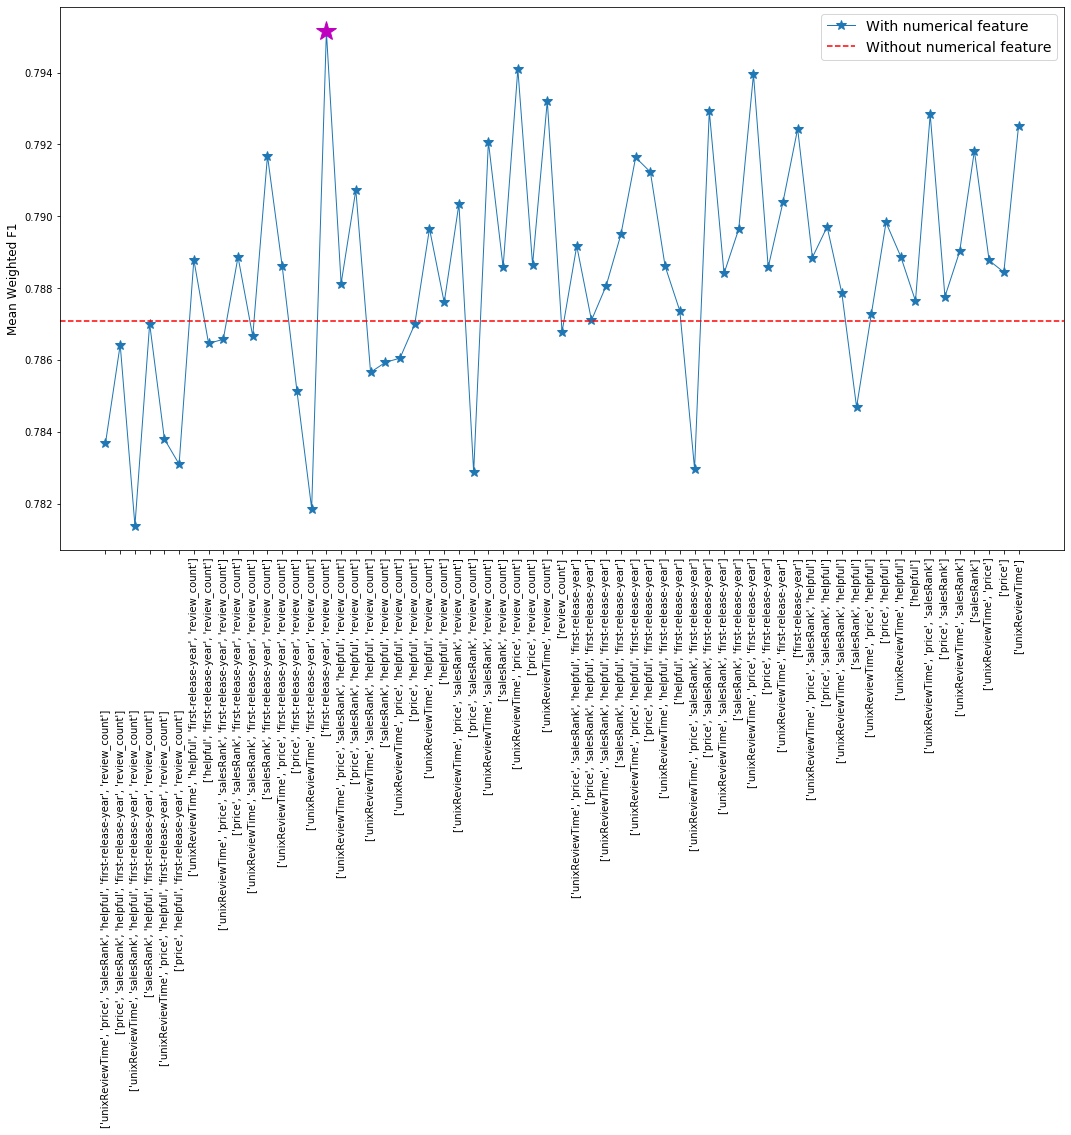

In [123]:
fig, ax = plt.subplots(figsize=(18,10))
ax.set_ylabel('Mean Weighted F1', fontsize=12)
ax.set_xticklabels(xticklabels, rotation = 90, va="top", position=(0,-0.28))
plt.xticks(range(0, len(xticklabels)), fontsize=10)
plt.plot(range(len(feature_combination)-1), LR_performance_list, lw=1, marker='*', markersize=10, label="With numerical feature")
plt.plot([k_LR], [v_LR], marker='*', markersize=20, color='m')
#plt.text(k_LR+1, v_LR, "0.795", fontsize=12)
ax.axhline(y=0.7870939821839049, color='r', ls='--', label="Without numerical feature")
plt.legend(fontsize=14)
plt.savefig('performance-d4.png')
plt.show()

### Bagging

In [ ]:
"""
# Testing
if not useTestCSV:
    # Run ML
    kf = sklearn.model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    #kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)
    f1_vals_log = []
    f1_vals_rnd = []
    f1_vals_svm = []
    f1_vals_gnb = []
    f1_vals_voting = []
    f1_vals_bagging = []
    
    log_clf = sklearn.linear_model.LogisticRegression(max_iter=100000, class_weight='balanced')
    # for soft
    #svm_rbf_clf = SVC(kernel='linear', probability=True)
    # for hard
    svm_rbf_clf = SVC(kernel='linear')
    rnd_clf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
    MNBclf = MultinomialNB()
    gnb_clf = sklearn.naive_bayes.GaussianNB()
    #voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svm', svm_rbf_clf)], voting='hard')
    voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svm', svm_rbf_clf)], voting='hard')
    
    # Bagging classifier
    bag_clf = BaggingClassifier(
        rnd_clf, n_estimators=500, max_samples=3000, bootstrap=True, n_jobs=-1)
    
    for train_index, test_index in kf.split(Xtrain):
        x_train, x_test = Xtrain[train_index], Xtrain[test_index]
        y_train, y_test = ytrain[train_index], ytrain[test_index]
        
        print("==================================================")
        bag_clf.fit(x_train, y_train)
        f1 = sklearn.metrics.f1_score(y_test, bag_clf.predict(x_test), average='weighted')
        f1_vals_bagging.append(f1)
        print("F1 {}".format(f1))
        
    print("Mean F1 bagging: ", statistics.mean(f1_vals_bagging))
    #print("Mean F1 LR: ", statistics.mean(f1_vals_log))
    #print("Mean F1 RF: ", statistics.mean(f1_vals_rnd))
    #print("Mean F1 SVM: ", statistics.mean(f1_vals_svm))
    #print("Mean F1 voting: ", statistics.mean(f1_vals_voting))
"""

In [ ]:
# 2000 year: 0.718
# only helpful: 0.720

# hard: increase
# soft: decrease
# without estimation decrease 0.726